# Import and Clean Dataset

In [419]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import json
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
%matplotlib inline 
# make matplotlib display inline 

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


./Data/US/HoChiMinhCity_PM2.5_2016_YTD.csv
./Data/US/HoChiMinhCity_PM2.5_2017_YTD.csv
n_sample from csv : 15336
n_sample after clear: 14043


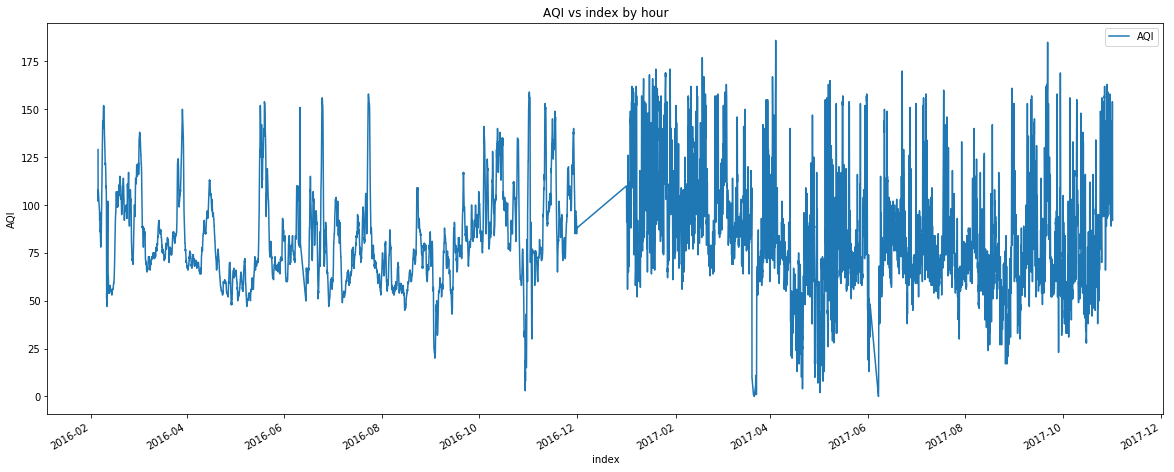

In [386]:
path = "./Data/US/"
df = pd.DataFrame()
for file in sorted(os.listdir(path)):
    print(path+file)
    # concatinate file
    df = df.append(pd.read_csv(path+file),ignore_index = True)
#Extract date time
df['Date (LT)'] = pd.to_datetime(df['Date (LT)'])
df = df.rename(columns={'Date (LT)': 'Date'})

# filter out valid column

df2 = df.loc[:,['Date','Hour','Day','Month','Year','AQI']]
df2 = df2.sort_values(by='Date') # sort by time
print("n_sample from csv : {}".format(len(df2.index)))
df2 = df2[df2['AQI'] > -100]# remove invalid AQI , less than 0
df2 = df2.reset_index(drop=True) # reset index after remove unwanted row
print("n_sample after clear: {}".format(len(df2.index)))

# visuallize

#plt.plot(df2['AQI'][::100])
df2.plot(x='Date',y='AQI',figsize=(20,8))
plt.ylabel('AQI')
plt.xlabel('index')
plt.title('AQI vs index by hour')
plt.show()

In [215]:
# function calculate day summary
def day_summary(df):
    out= pd.DataFrame(columns=['Date','Average','Max','Min'])
    while(len(df.index) > 1):
        i = df.itertuples()
        index,date_index,hour,day,month,year,_ = next(i)
        t  = df[(df['Day'] == day) & (df['Month'] == month) & (df['Year'] == year)] # chain conditon
        average_day = sum(t['AQI'])/len(t.index)
        max_day = max(t['AQI'])
        min_day = min(t['AQI'])
        ts = pd.Series([date_index.date(),average_day,max_day,min_day], index=['Date','Average','Max','Min'])
        out = out.append(ts,ignore_index=True) # add new row to day
        df = df.drop(t.index) # remove processed day
    out = out.sort_values(by='Date')
    out = out.reset_index(drop=True)
    return out

df3 = day_summary(df2)





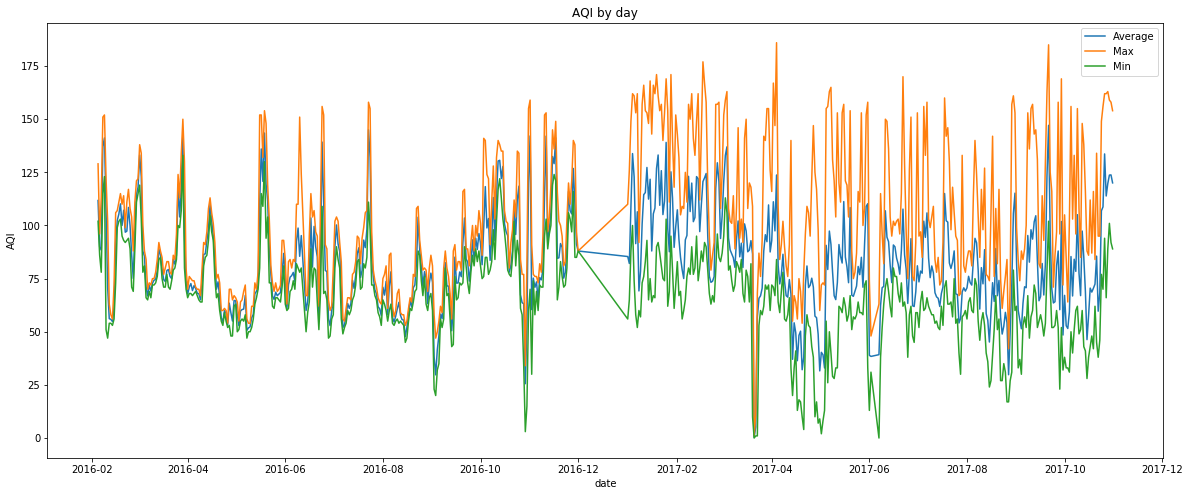

In [216]:
plt.figure()
df3.plot(x='Date',figsize=(20,8))
plt.ylabel('AQI')
plt.xlabel('date')
plt.title('AQI by day')
plt.legend()
plt.show()

In [229]:
path = "./Data/Weather/wunderground/VVTS_20171115_summary.csv"
# read csv in
df = pd.read_csv(path)
# clean up invalid columns

print(len(df.columns))
df = df.dropna(axis=0,how='all') # drop row with all nan number
df = df.dropna(axis=1,how='all') # drop cloumns with all nan number
print(len(df.columns))
# remove colums with the same value

nunique = df.apply(pd.Series.nunique)  # apply nunique method to dataframe columns
cols_to_drop = nunique[nunique == 1].index # get index with nunique == 1
df = df.drop( cols_to_drop,axis=1)
# convert date to datetime series
   
for index,row in df.iterrows():
  
    # get date colum
    t = row.date
    t = t.replace("'",'"')
    t = json.loads(t) # load back dictionary 
    date_index = dt.datetime(year = int(t['year']),month = int(t['mon']),day = int(t['mday']))
    df_x = df.set_value(index,'date',date_index.date())
df_x = df_x.sort_values(by='date')
df_x = df_x.rename(columns={'date':'Date'})
df_x = df_x.set_index(pd.DatetimeIndex(df_x['Date']))


#pd.to_datetime(df['date'],format="")





71
49


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


## Linear Logistic Regression Model

In [420]:
df3 = df3.set_index(pd.DatetimeIndex(df3['Date']))
# Merge input and output 
merge=pd.merge(df3,df_x, how='inner', left_index=True, right_index=True)
merge = merge.drop('Date_y',axis=1)
merge = merge.drop('Max',axis =1)
merge = merge.drop('Min',axis =1)
dataset = merge.drop('Date_x',axis=1)
print("Total sample in data set: {}".format(len(dataset.index)))
print("Total colums in data set: {}".format(len(dataset.columns)))
def aqi_to_apl(x):
    if(x in range(0,51)):
        return 0
    elif( x in range(51,100)):
        return 1
    elif( x in range(100,151)):
        return 2
    elif( x in range(151,201)):
        return 3
    elif( x in range(201,251)):
        return 4
    elif( x in range(251,301)):
        return 5
    else : 
        return 6
def normalize_data(data):
	data = np.asarray(data,dtype=np.float32)
	mean = data.mean(axis=0)
	std = data.std(axis=0)
	data = (data - mean) / std
	return data

# Convert AQI to Air polution level 
for index,row in dataset.iterrows():
    dataset = dataset.set_value(index,'Average',aqi_to_apl(int(row.Average)))
    #dataset = dataset.set_value(index,'Max',aqi_to_apl(int(row.Max)))
    #dataset = dataset.set_value(index,'Min',aqi_to_apl(int(row.Min)))
    
# convert object to int
# get list of unique value
da = np.unique(dataset['meanwdire'])
# zip to dictionary
da = dict(zip(da,range(len(da))))
# replace columns with dic
dataset['meanwdire'] = dataset['meanwdire'].replace(da)




Total sample in data set: 481
Total colums in data set: 41


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [446]:
import tensorflow as tf
#step 1 define hyper_para
learning_rate = 0.01
num_epoch = 25000
costs = []
# Step 2 : 
# Get label y and encode it into number
y = np.array(dataset['Average']) # convert dataset to numpy array
num_labels = len((np.unique(y))) # 
# convert y to one-hot vector

y = (np.arange(num_labels) == y[:, None]).astype(np.float32) 
x = np.array(dataset.iloc[:,1:].astype(np.float32)) # skip first column
standard_scaler = StandardScaler()
x_std = standard_scaler.fit_transform(x)
num_samples,num_features = x.shape
batch_size = num_samples # batch regression 
tf.reset_default_graph()
data = tf.placeholder(tf.float32, shape = [None,num_features], name="X")
labels = tf.placeholder(tf.float32, shape = [None,num_labels] ,name="Y")
test_data = tf.placeholder(tf.float32, shape = [None,num_features], name="X_Test")
# Define Weight and biased
weights = tf.Variable(tf.truncated_normal([num_features, num_labels]))
biases = tf.Variable(tf.zeros([num_labels]))
# Define loss function 
logits = tf.matmul(data, weights) + biases
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
# Optimizer.
#  find the minimum of this loss using gradient descent.
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
# Test result 
train_prediction = tf.nn.softmax(logits)
test_prediction = tf.nn.softmax(tf.matmul(test_data, weights) + biases)
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


    

Initialized
Loss at epoch 0: epoch 2.816990
Training accuracy: 37.5%
Test accuracy: 35.3%
Loss at epoch 1000: epoch 0.543701
Training accuracy: 79.2%
Test accuracy: 53.1%
Loss at epoch 2000: epoch 0.328284
Training accuracy: 85.4%
Test accuracy: 60.0%
Loss at epoch 3000: epoch 0.241543
Training accuracy: 89.6%
Test accuracy: 62.6%
Loss at epoch 4000: epoch 0.192922
Training accuracy: 93.8%
Test accuracy: 64.0%
Loss at epoch 5000: epoch 0.160064
Training accuracy: 95.8%
Test accuracy: 64.7%
Loss at epoch 6000: epoch 0.136212
Training accuracy: 97.9%
Test accuracy: 64.9%
Loss at epoch 7000: epoch 0.118212
Training accuracy: 97.9%
Test accuracy: 64.7%
Loss at epoch 8000: epoch 0.104234
Training accuracy: 100.0%
Test accuracy: 65.4%
Loss at epoch 9000: epoch 0.093116
Training accuracy: 100.0%
Test accuracy: 65.4%
Loss at epoch 10000: epoch 0.084091
Training accuracy: 100.0%
Test accuracy: 65.6%
Loss at epoch 11000: epoch 0.076635
Training accuracy: 100.0%
Test accuracy: 65.4%
Loss at epoch

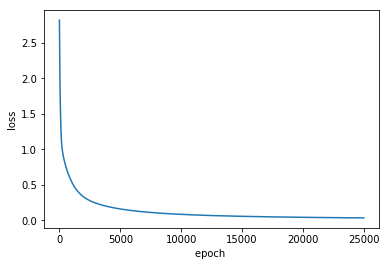

Completed Regression


In [447]:

# Run model
costs = []
train_acc = []
test_acc = []
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print('Initialized')
    x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size = 0.9)
    for step in range(num_epoch):
        # Run the computations. 
        #shuffle data
        
        feed_dict = {data:x_train,labels:y_train,test_data:x_test}
        _, l, p,t = sess.run(
            [optimizer, loss, train_prediction,test_prediction], feed_dict=feed_dict)
        if (step % 1000 == 0):
          print('Loss at epoch %d: epoch %f' % (step, l))
          print('Training accuracy: %.1f%%' % accuracy(p, y_train))
          print('Test accuracy: %.1f%%' % accuracy(t, y_test))
        costs.append(l)
        train_acc.append(p)
        test_acc.append(t)
        
    plt.figure()
    plt.plot(costs)
    plt.xlabel('epoch ')
    plt.ylabel('loss')
    plt.show()
   
    
    
    
print('Completed Regression')

# Finding
After 8000 eopach (90% train , 10 % test, 481 samples)

Our model reach 100% accuracy in train set and 66% correct in testset
